## Purpose

This project is to help determine if ML models, specifically those optimized for anomaly detection, could be trained to detect if normal system utilities behave differently when being used as a GTFObin on a Linux system.

GTFO bins are common Linux (or Unix) utilities that can be used by adversaries in the course of an attack. Since these are normal system utilities, they do not stand out on endpoint detection unless they're being flagged for specific use cases, which might be evaded.

For this project, openssl was used as the primary example, since can be used with a couple of other utilities to provide an encrypted reverse shell.

Examples of openssl and other utilities being used in this manner can be found here: https://gtfobins.github.io/#+reverse%20shell

To detect the process activity, eBPF was used, which can be used to trace at the kernel level every system call a process makes.


### Details

Writing a program that utilized eBPF was certainly the most difficult portion of the project, initially I tried to use Rust, since it is an upcoming C replacement language and has eBPF libaries. However, I found the libraries to not be well documented yet and had great difficulty getting them to compile, much less attach probes to the kernel and collect the data I needed. I also tried normal C and Python and was partially successful. During one of my searches for more information, I did fall upon research by Simone Margaritelli aka "Evil Socket" who made a blog post with accompanying code about doing very nearly the same thing I was trying, but using Tensorflow and only capturing data on a single process at a time. I was able to use his code as a basis to capture all process usage data since I needed not just openssl, but the data of the other processes it was interacting with and child processes, etc. I only utilized the portion of his code that produced a histogram of the raw system calls (output as a csv file).

For more information on eBPF, these videos provide a good introduction:
- [Video - eBPF: Unlocking the Kernel](https://www.youtube.com/watch?v=Wb_vD3XZYOA)
- [Free eBook - What is eBPF?](https://isovalent.com/books/ebpf/)


I was able to use the modified code to capture 30 minutes of typical system usage, then a separate capture where openssl was used for a reverse shell and several commands were issued typical of an attacker. My hope was to train the model on normal system behavior and then have it see if the malicious usage of openssl appeared anomalous.

Similar research can be found here:

https://arxiv.org/abs/2112.09008

https://arxiv.org/abs/2401.05641v1

https://arxiv.org/abs/2402.18329

The post by "Evil Socket": https://www.evilsocket.net/2022/08/15/Process-behaviour-anomaly-detection-using-eBPF-and-unsupervised-learning-Autoencoders/


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I've been taking the course.fast.ai course on the side when I have time. I wanted to use it and pytorch as much as possible.

In [13]:
#Import all the necessary libraries
import pandas as pd
from fastai.tabular.all import *
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [7]:
# Load the datasets
normal_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NYU Machine Learning Course/datasets/normal.csv')
abnormal_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NYU Machine Learning Course/datasets/openssl_abnormal.csv')

# Drop the 'sample_time' column since likely not needed
normal_data = normal_data.drop('sample_time', axis=1)
anomalous_data = abnormal_data.drop('sample_time', axis=1)

In [8]:
# Custom dataset class
class AnomalyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create a custom dataset
train_dataset = AnomalyDataset(normal_data)

# Create a data loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [9]:
# Define the autoencoder model
class AnomalyDetector(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x, *args, **kwargs):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
#Train the model on the normal data or process activity and system calls.
# Create an instance of the anomaly detector
input_dim = normal_data.shape[1]
model = AnomalyDetector(input_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0004
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [29]:
# Convert anomalous data to a PyTorch tensor
anomalous_tensor = torch.tensor(anomalous_data.values, dtype=torch.float32)

# Get the model's predictions on the anomalous data
with torch.no_grad():
    reconstructed = model(anomalous_tensor)

# Calculate the reconstruction error
mse_loss = nn.MSELoss(reduction='none')
reconstruction_error = mse_loss(anomalous_tensor, reconstructed).mean(dim=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error.numpy(), 95)

# Classify anomalies based on the reconstruction error
anomalies = (reconstruction_error > threshold).numpy()

In [31]:
# Count the number of detected anomalies
num_anomalies = anomalies.sum()
total_samples = len(anomalies)

print(f"Number of anomalies detected: {num_anomalies}")
print(f"Total samples: {total_samples}")
print(f"Percentage of anomalies: {num_anomalies / total_samples * 100:.2f}%")

Number of anomalies detected: 16
Total samples: 309
Percentage of anomalies: 5.18%


Now that the model has been trained, I will run it against the known abnormal usage of openssl (using it to run a reverse shell while typing commands) and see if it detects a high anomaly rate.

#### Visualization

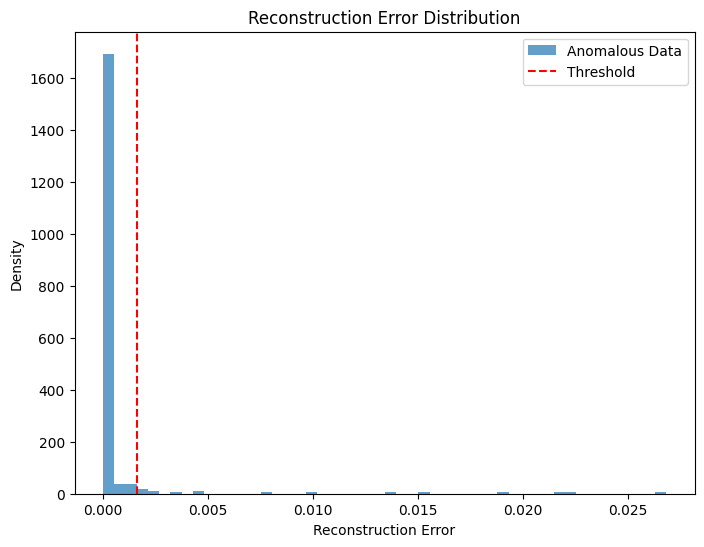

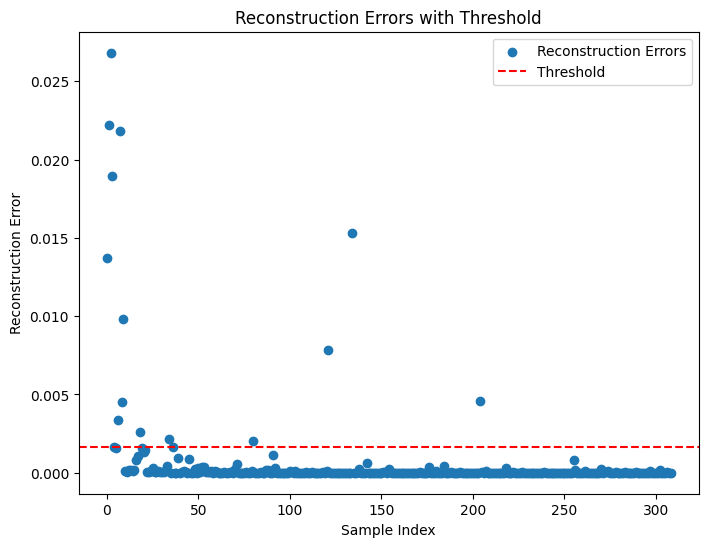

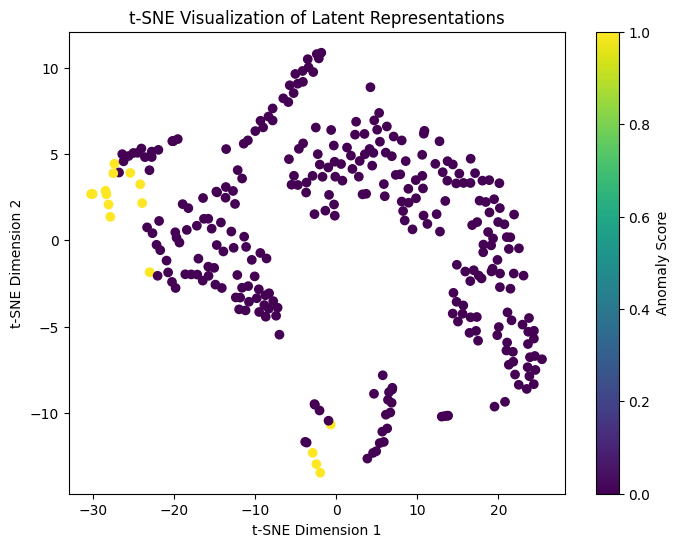

In [33]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reconstruction Error Distribution
plt.figure(figsize=(8, 6))
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.7, label='Anomalous Data')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

# Threshold Visualization
plt.figure(figsize=(8, 6))
plt.scatter(range(len(anomaly_scores)), anomaly_scores, label='Reconstruction Errors')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors with Threshold')
plt.legend()
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
latent_representations = []
with torch.no_grad():
    for data in anomalous_loader:
        latent = model.encoder(data).numpy()
        latent_representations.extend(latent)
latent_representations = np.array(latent_representations)
tsne_results = tsne.fit_transform(latent_representations)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=anomalies, cmap='viridis', label='Anomalies')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Latent Representations')
plt.colorbar(label='Anomaly Score')
plt.show()

Unfortunately, there doesn't seem to be a significant increase in the amount of anomalous system calls when using openssl in a malicious or untypical manner. This kind of leans towards why adversaries like to use system tools since their usage is common and does not stand out on a system, it appears even the system calls they make when being used in an unusual way have the same anomaly rate as the normal system usage data set.

It could also be that more data needs to be collected, of both normal system usage, and normal utilities being used abnormally.

That said, maybe this model isn't the best for it, or more data may need to be collected to establish more of a baseline. First I will attempt some model tuning. Starting with L1 and L2 regularization.

In [14]:
#Define the Anomaly Detection Class with the ability to do L1/L2 Regularization

class AnomalyDetector(nn.Module):
    def __init__(self, input_dim, l1_weight=0.0, l2_weight=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def l1_regularization(self):
        l1_reg = torch.tensor(0., requires_grad=True)
        for param in self.parameters():
            l1_reg = l1_reg + torch.norm(param, 1)
        return self.l1_weight * l1_reg

    def l2_regularization(self):
        l2_reg = torch.tensor(0., requires_grad=True)
        for param in self.parameters():
            l2_reg = l2_reg + torch.norm(param, 2)**2
        return self.l2_weight * l2_reg

In [26]:
# Create an instance of the anomaly detector with L1 and L2 regularization
input_dim = normal_data.shape[1]
tuned_model = AnomalyDetector(input_dim, l1_weight=0.01, l2_weight=0.01)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(tuned_model.parameters(), lr=0.001)


# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        # Forward pass
        outputs = tuned_model(data)
        reconstruction_loss = criterion(outputs, data)
        l1_reg = tuned_model.l1_regularization()
        l2_reg = tuned_model.l2_regularization()
        loss = reconstruction_loss + l1_reg + l2_reg

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/20], Loss: 0.3739
Epoch [2/20], Loss: 0.1924
Epoch [3/20], Loss: 0.1910
Epoch [4/20], Loss: 0.1897
Epoch [5/20], Loss: 0.1874
Epoch [6/20], Loss: 0.1888
Epoch [7/20], Loss: 0.1850
Epoch [8/20], Loss: 0.1848
Epoch [9/20], Loss: 0.1866
Epoch [10/20], Loss: 0.1888
Epoch [11/20], Loss: 0.1873
Epoch [12/20], Loss: 0.1878
Epoch [13/20], Loss: 0.1856
Epoch [14/20], Loss: 0.1858
Epoch [15/20], Loss: 0.1881
Epoch [16/20], Loss: 0.1928
Epoch [17/20], Loss: 0.1909
Epoch [18/20], Loss: 0.1922
Epoch [19/20], Loss: 0.1924
Epoch [20/20], Loss: 0.1921


Showing more loss with L1 and regularization set to 0.01 and L2 the same value.

Example (L1 at 0.01, L2 at 0.01):

> `Epoch [10/10], Loss: 0.1886`

Example (L1 at 0.02, L2 at 0.01):

> `Epoch [10/10], Loss: 0.3726`

Increasing L1 lead to more loss. So leaving it at defaults (0.0) probably for the best. I can also adjust the learning rate to be slower and increase the number of epochs.

Decreasing the learning rate lead to less loss, which likely means the model was still possibly overfit. Increasing the epochs to double (20) lead to slightly higher loss of 0.19 when L1 was set to 0.01

> `Epoch [20/20], Loss: 0.1921`

To further optimize the model though, I would likely need more data to test against. Still would like to



In [30]:
# Convert anomalous data to a PyTorch tensor
anomalous_tensor = torch.tensor(anomalous_data.values, dtype=torch.float32)

# Get the model's predictions on the anomalous data
with torch.no_grad():
    reconstructed = tuned_model(anomalous_tensor)

# Calculate the reconstruction error
mse_loss = nn.MSELoss(reduction='none')
reconstruction_error = mse_loss(anomalous_tensor, reconstructed).mean(dim=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error.numpy(), 95)

# Classify anomalies based on the reconstruction error
anomalies = (reconstruction_error > threshold).numpy()

In [32]:
# Count the number of detected anomalies
num_anomalies = anomalies.sum()
total_samples = len(anomalies)

print(f"Number of anomalies detected: {num_anomalies}")
print(f"Total samples: {total_samples}")
print(f"Percentage of anomalies: {num_anomalies / total_samples * 100:.2f}%")

Number of anomalies detected: 16
Total samples: 309
Percentage of anomalies: 5.18%


Despite the tuning, there was no difference in anomaly detection. Other than to say the slightly higher loss means the model is less likely to be overfit.

### Gradient Based Decision Tree

There is something else I would like to try based on the research from [Living-off-The-Land Reverse-Shell Detection by Informed Data Augmentation](https://arxiv.org/abs/2402.18329). Published just shortly before starting my own research.

In their research, they used a Gradient Based Decision Tree. This might have better performance since its not running a full neural network to analyze system calls. This would be more ideal in evaluating live data. To train the GBDT, I will attempt to pull out the syscalls the Autoencoder model flags as anomalous, and train the GBDT for normal vs anomalous system calls. In this case, I will be using the Autoencoder to preclassify or label the system calls as a preprocessing step to training the GBDT. I will use the tuned_model at about a 19% loss since it didn't effect the end results.



In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have trained the AnomalyDetector model
model.eval()

# Label the anomalous data
anomaly_scores = []
with torch.no_grad():
    for data in anomalous_loader:
        outputs = model(data)
        reconstruction_errors = torch.mean((data - outputs) ** 2, dim=1)
        anomaly_scores.extend(reconstruction_errors.numpy())

threshold = np.percentile(anomaly_scores, 95)
anomalous_labels = [1 if error > threshold else 0 for error in anomaly_scores]

# Prepare the training data for GBDT
X_train = np.concatenate((normal_data, anomalous_data), axis=0)
y_train = np.concatenate((np.zeros(len(normal_data)), np.array(anomalous_labels)), axis=0)

# Create and train the GBDT model
gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbdt.fit(X_train, y_train)

# Evaluate the GBDT model on the test data
X_test = anomalous_data
if hasattr(X_test, 'columns'):
    X_test = X_test.values  # Convert DataFrame to NumPy array
y_test = np.array(anomalous_labels)
y_pred = gbdt.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 1.0
Recall: 1.0
F1-score: 1.0


Below is the trained GBDT and it's criteria for classifying anomalous data.

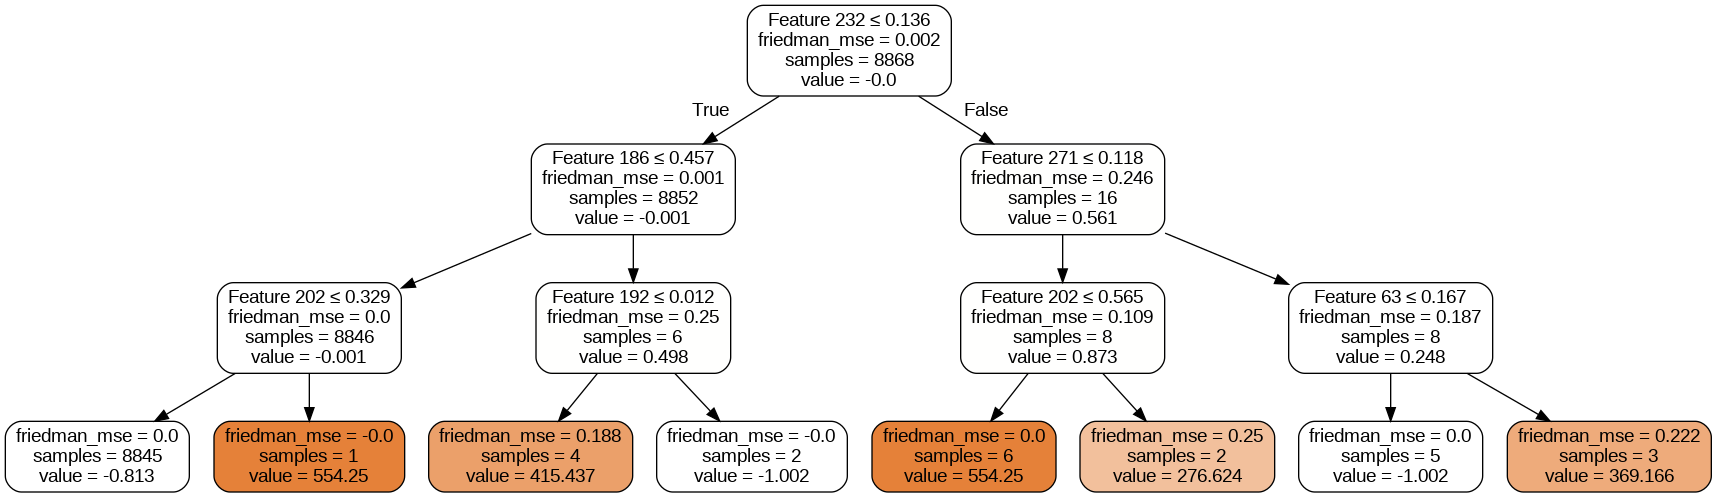

In [40]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image, display

# Extract a single decision tree from the GBDT model
tree = gbdt.estimators_[0, 0]  # Access the first decision tree

# Export the decision tree as a dot file
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=[f"Feature {i}" for i in range(X_train.shape[1])],
                           class_names=["Normal", "Anomalous"],
                           filled=True, rounded=True,
                           special_characters=True)

# Create a graphviz graph from the dot data
graph = graphviz.Source(dot_data, format='png')

# Display the graph as a PNG image in the Jupyter Notebook
display(Image(graph.pipe()))

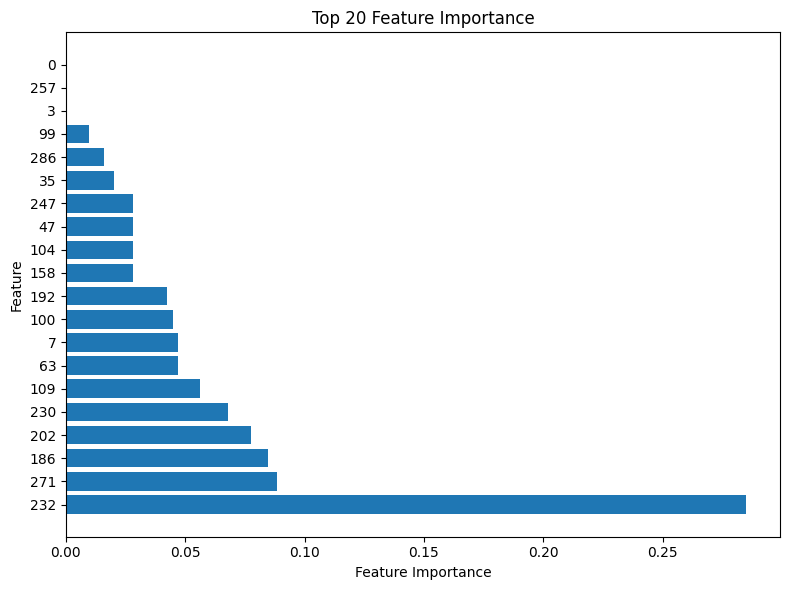

In [45]:
import matplotlib.pyplot as plt

# Specify the number of top features to display
top_n = 20  # Change this to the desired number of top features

# Feature Importance Visualization
feature_importance = gbdt.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order
top_indices = sorted_idx[:top_n]  # Select the indices of the top N features

fig = plt.figure(figsize=(8, 6))
plt.barh(range(top_n), feature_importance[top_indices], align="center")
plt.yticks(range(top_n), top_indices)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importance")

plt.tight_layout()
plt.show()

The above features are part of system calls in a histogram, and do not have a human readable label. The numbers likely correspond to the number in the sys_# field of each of the system calls. As you can see in the below example there are 512 features being recorded in the system call eBPF data.

In [49]:
# Display the first 5 lines of normal_data
print("First 5 lines of normal_data:")
print(normal_data.head(5))

First 5 lines of normal_data:
      sys_0     sys_1  sys_2     sys_3  sys_4  sys_5  sys_6     sys_7  \
0  1.000000  0.000000    0.0  1.000000    0.0    0.0    0.0  0.000000   
1  0.945946  1.000000    0.0  0.972973    0.0    0.0    0.0  1.000000   
2  0.229167  0.300000    0.0  0.139535    0.0    0.0    0.0  0.333333   
3  0.111111  0.354839    0.0  0.000000    0.0    0.0    0.0  0.250000   
4  0.084746  0.031250    0.0  0.104167    0.0    0.0    0.0  0.428571   

      sys_8  sys_9  ...  sys_502  sys_503  sys_504  sys_505  sys_506  sys_507  \
0  1.000000    0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
1  0.285714    1.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
2  0.125000    0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
3  0.111111    0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
4  0.100000    0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   

   sys_508  sys_509  sys_510  sys_511  
0   

Thanks for reading my report.



---


Z.S. David Mitchell